In [1]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

In [35]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5
VAL_RATIO = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_CSV = "augmented_data.csv"
OUTPUT_DIR = "preprocessed_tensors"
OUTPUT_CSV = "augmented_data_tensor.csv"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

df = pd.read_csv(INPUT_CSV)
tensor_paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    path = row['path']
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping unreadable image: {path}")
            tensor_paths.append("")
            continue

        img = apply_clahe(img)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = img.astype(np.float32) / 255.0
        img = (img - 0.5) / 0.5
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: [1, H, W]

        tensor_name = f"img_{i:05d}.pt"
        tensor_path = os.path.join(OUTPUT_DIR, tensor_name)
        torch.save(img_tensor, tensor_path)
        tensor_paths.append(tensor_path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        tensor_paths.append("")

df["tensor_path"] = tensor_paths
df.to_csv(OUTPUT_CSV, index=False)

print("Done. Tensors saved and CSV updated.")

100%|██████████| 53879/53879 [15:00<00:00, 59.81it/s]


Done. Tensors saved and CSV updated.


In [ ]:
df["labels_list"] = df["labels"].apply(lambda x: x.split("|"))

mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df["labels_list"])

for i, label in enumerate(mlb.classes_):
    df[label] = label_matrix[:, i]

df.to_csv(OUTPUT_CSV, index=False)

In [37]:
class TensorImageDataset(Dataset):
    def __init__(self, csv_file, label_columns):
        self.data = pd.read_csv(csv_file)
        self.label_columns = label_columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tensor_path = self.data.iloc[idx]['tensor_path']
        image_tensor = torch.load(tensor_path)

        label = self.data.iloc[idx][self.label_columns].values.astype("float32")
        label_tensor = torch.tensor(label)

        sample_weight = self.data.iloc[idx]["sample_weight"]
        weight_tensor = torch.tensor(sample_weight, dtype=torch.float32)

        return image_tensor, label_tensor, weight_tensor


In [38]:
df_full = pd.read_csv(OUTPUT_CSV)
mlb = MultiLabelBinarizer()
mlb.fit(df_full['labels_list'].apply(eval))
LABEL_COLUMNS = mlb.classes_.tolist()

dataset = TensorImageDataset(OUTPUT_CSV, LABEL_COLUMNS)
val_size = int(len(dataset) * VAL_RATIO)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
cw_df = pd.read_csv("class_weights.csv")
cw_dict = dict(zip(cw_df['label'], cw_df['class_weight']))
class_weights = np.array([cw_dict[label] for label in mlb.classes_], dtype=np.float32)
class_weights_tensor = torch.tensor(class_weights).to(DEVICE)

In [40]:
model = models.densenet121(pretrained=True)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, len(mlb.classes_)),
    nn.Sigmoid()
)
model = model.to(DEVICE)

criterion = nn.BCELoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

d:\Project\python\DiagnosticSystemForChestX-rayImageClassification\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Project\python\DiagnosticSystemForChestX-rayImageClassification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
def train_one_epoch():
    model.train()
    total_loss = 0
    for imgs, labels, weights in tqdm(train_loader):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        weights = weights.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        if loss.dim() > 0:
            loss = (loss * weights.unsqueeze(1)).mean()
        else:
            loss = (loss * weights).mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch()
    print(f"Train Loss: {train_loss:.4f}")


Epoch 1/5


100%|██████████| 1347/1347 [46:20<00:00,  2.06s/it]


Train Loss: 0.1606
Epoch 2/5


100%|██████████| 1347/1347 [38:00<00:00,  1.69s/it]


Train Loss: 0.1351
Epoch 3/5


100%|██████████| 1347/1347 [37:55<00:00,  1.69s/it]


Train Loss: 0.1225
Epoch 4/5


100%|██████████| 1347/1347 [38:23<00:00,  1.71s/it]


Train Loss: 0.1104
Epoch 5/5


100%|██████████| 1347/1347 [38:18<00:00,  1.71s/it]

Train Loss: 0.0962



Evaluating on validation set...

Validation Metrics:
Precision: 0.5684, Recall: 0.2861, F1-score: 0.3601, AUC: 0.8252

Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.52      0.23      0.31      1829
      Cardiomegaly       0.74      0.44      0.55       804
     Consolidation       0.56      0.14      0.22      1273
             Edema       0.55      0.28      0.37       642
          Effusion       0.62      0.42      0.50      2148
         Emphysema       0.52      0.41      0.45       688
          Fibrosis       0.51      0.29      0.37       652
            Hernia       0.84      0.79      0.81       217
      Infiltration       0.56      0.26      0.36      3181
              Mass       0.52      0.12      0.19       945
            Nodule       0.33      0.02      0.03       996
Pleural_Thickening       0.39      0.19      0.26       987
         Pneumonia       0.81      0.14      0.24       439
      Pneumothor

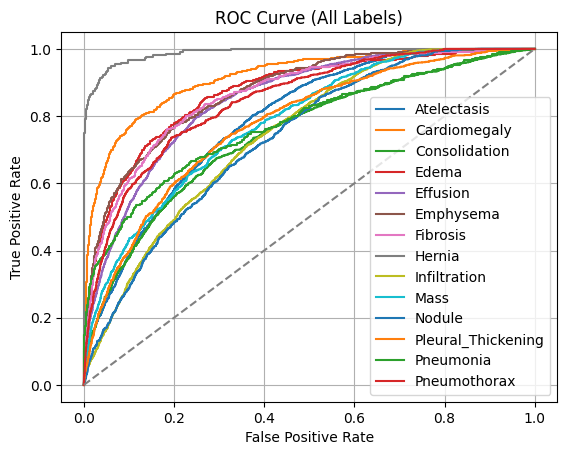

In [ ]:
def evaluate():
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            y_prob.extend(outputs.cpu().numpy())
            y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, average="macro")
    except:
        auc = float('nan')

    print(f"\nValidation Metrics:\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, AUC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))

    print("\nPlotting ROC Curves...")
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{mlb.classes_[i]}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve (All Labels)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


print("\nEvaluating on validation set...")
evaluate()

In [44]:
torch.save(model.state_dict(), "model.pth")